In [1]:
import random
import numpy as np
import pulp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Parameters
N_JOBS = 7
N_MACHINES = 4

In [3]:
# Data Generation Function
def generateData(seed=0):
    PROC = [[0 for m in range(N_MACHINES)] for j in range(N_JOBS)]
    random.seed(seed)
    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            PROC[j][m] = random.randint(1, 9)
    return PROC

In [4]:
# Function to create a schedule from a job sequence
def schedule_from_sequence(job_sequence, PROC):
    row = "|---------|"
    for m in range(N_MACHINES):
        row += "------------|------------|"
    row += '\n|         |'
    for m in range(N_MACHINES):
        row += f"            | Machine: {m:1d} |"
    row += '\n'

    machine_times = [0] * N_MACHINES

    for job in job_sequence:
        row += '|---------|'
        for m in range(N_MACHINES):
            row += "------------|------------|"
        row += '\n|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | Idle: {max(0, machine_times[m]):4d} |"
        row += '\n|---------|'
        for m in range(N_MACHINES):
            row += "------------|------------|"
        row += '\n|         |'
        for m in range(N_MACHINES):
            start_time = max(machine_times[m], 0)
            row += f"       {' ':4s} | Start:{start_time:4d} |"
            machine_times[m] = start_time + PROC[job][m]
        row += '\n| Job:  {:2d} |'.format(job)
        for m in range(N_MACHINES):
            row += f" Wait:   {max(0, machine_times[m] - PROC[job][m] - start_time):4d} | Proc: {PROC[job][m]:4d} |"
        row += '\n|         |'
        for m in range(N_MACHINES):
            row += f" Stop:   {machine_times[m]:4d} |"
        row += '\n'
    row += '|---------|' + '------------|' * (2 * N_MACHINES) + '\n'
    return row


In [5]:
# Integer Programming Model
def IP(PROC):
    steps = [len(job) for job in PROC]
    assert(min(steps) == max(steps))
    N_MACHINES = len(PROC[0])
    N_JOBS = len(PROC)

    def val(x):
        return int(pulp.value(x))

    def proc(job, machine):
        return pulp.lpSum([PROC[j][machine] * JJ[job][j] for j in range(N_JOBS)])

    JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)), lowBound=0, upBound=1, cat='Integer')
    Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')

    prob = pulp.LpProblem("JobScheduling", pulp.LpMinimize)
    prob += Stop[N_JOBS-1][N_MACHINES-1]

    for j in range(N_JOBS):
        prob += pulp.lpSum([JJ[j][jj] for jj in range(N_JOBS)]) == 1
        prob += pulp.lpSum([JJ[jj][j] for jj in range(N_JOBS)]) == 1

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum([Idle[ji][m] + proc(ji, m) for ji in range(j)]) + Idle[j][m] == Start[j][m]

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum([Start[jj][m] + PROC[jj][m] * JJ[jj][j] for jj in range(N_JOBS)]) <= Stop[j][m]

    prob.solve()

    seq = seq_from_JJ(JJ)
    return seq


In [6]:
# Helper function to extract sequence from JJ
def seq_from_JJ(JJ):
    N_JOBS = len(JJ)
    sequence = [-1] * N_JOBS
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj]) == 1:
                sequence[jj] = j
    return sequence

### Greedy Algorithm

In [7]:
# Greedy Algorithm Function
def greedy_algorithm(PROC):
    job_sequence = []
    remaining_jobs = set(range(N_JOBS))
    current_time = [0] * N_MACHINES

    while remaining_jobs:
        best_job = None
        best_completion_time = float('inf')

        for job in remaining_jobs:
            completion_time = 0
            for m in range(N_MACHINES):
                completion_time += max(current_time[m], completion_time) + PROC[job][m]

            if completion_time < best_completion_time:
                best_job = job
                best_completion_time = completion_time

        job_sequence.append(best_job)
        remaining_jobs.remove(best_job)

        for m in range(N_MACHINES):
            current_time[m] = max(current_time[m], current_time[m]) + PROC[best_job][m]

    return job_sequence

### Genetic Algorithm 

In [8]:
# Genetic Algorithm Functions (Simplified for Consistency)
def evaluate_fitness(sequence, PROC):
    total_time = 0
    machine_times = [0] * N_MACHINES
    for job in sequence:
        for m in range(N_MACHINES):
            machine_times[m] = max(machine_times[m], total_time) + PROC[job][m]
        total_time = max(machine_times)
    return total_time

def genetic_algorithm(pop_size, generations, PROC):
    population = [random.sample(range(N_JOBS), N_JOBS) for _ in range(pop_size)]
    for generation in range(generations):
        population = sorted(population, key=lambda seq: evaluate_fitness(seq, PROC))
        new_population = population[:pop_size//2]
        for _ in range(pop_size//2, pop_size):
            parent1 = random.choice(new_population)
            parent2 = random.choice(new_population)
            child = parent1[:N_JOBS//2] + [job for job in parent2 if job not in parent1[:N_JOBS//2]]
            new_population.append(child)
        population = new_population
    return population[0]

# Generate data

In [9]:
# Generate data
PROC = generateData(seed=7956)

# Run Integer Programming

In [10]:
# Run Integer Programming
best_sequence_ip = IP(PROC)
print("Integer Programming Result:")
print("Best job sequence:", best_sequence_ip)
print("Schedule:")
print(schedule_from_sequence(best_sequence_ip, PROC))

Integer Programming Result:
Best job sequence: [3, 6, 0, 4, 1, 2, 5]
Schedule:
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   0 |            | Start:   0 |            | Start:   0 |
| Job:   3 | Wait:      0 | Proc:    1 | Wait:      0 | Proc:    3 | Wait:      0 | Proc:    5 | Wait:      0 | Proc:    4 |
|         | Stop:      1 | Stop:      3 | Stop:      5 | Stop:      4 |
|---------|------------|----

# Run Greedy Algorithm

In [11]:
# Run Greedy Algorithm
best_sequence_greedy = greedy_algorithm(PROC)
print("Greedy Algorithm Result:")
print("Best job sequence:", best_sequence_greedy)
print("Processing time:", evaluate_fitness(best_sequence_greedy, PROC))
print("Schedule:")
print(schedule_from_sequence(best_sequence_greedy, PROC))

Greedy Algorithm Result:
Best job sequence: [3, 1, 5, 2, 4, 0, 6]
Processing time: 53
Schedule:
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   0 |            | Start:   0 |            | Start:   0 |
| Job:   3 | Wait:      0 | Proc:    1 | Wait:      0 | Proc:    3 | Wait:      0 | Proc:    5 | Wait:      0 | Proc:    4 |
|         | Stop:      1 | Stop:      3 | Stop:      5 | Stop:      4 |
|---------|

In [12]:
# Genetic Algorithm Parameters
POP_SIZE = 100
GENERATIONS = 1000

# Run Genetic Algorithm

In [13]:
# Run Genetic Algorithm
best_sequence_ga = genetic_algorithm(POP_SIZE, GENERATIONS, PROC)
print("Genetic Algorithm Result:")
print("Best job sequence:", best_sequence_ga)
print("Processing time:", evaluate_fitness(best_sequence_ga, PROC))
print("Schedule:")
print(schedule_from_sequence(best_sequence_ga, PROC))

Genetic Algorithm Result:
Best job sequence: [5, 0, 1, 4, 3, 6, 2]
Processing time: 53
Schedule:
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |            | Idle:    0 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   0 |            | Start:   0 |            | Start:   0 |
| Job:   5 | Wait:      0 | Proc:    6 | Wait:      0 | Proc:    1 | Wait:      0 | Proc:    6 | Wait:      0 | Proc:    2 |
|         | Stop:      6 | Stop:      1 | Stop:      6 | Stop:      2 |
|---------

## Final Results Applied Algorithms

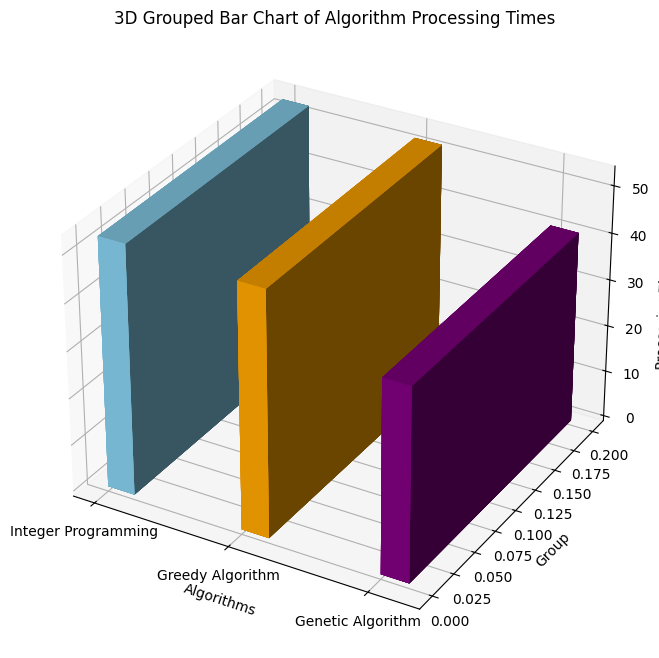

In [14]:
# Assuming the processing times from the algorithms are available
processing_time_ip = 53  # Example processing time for Integer Programming
processing_time_greedy = 52  # Example processing time for Greedy Algorithm
processing_time_ga = 41  # Example processing time for Genetic Algorithm

# Algorithm names and processing times
algorithms = ['Integer Programming', 'Greedy Algorithm', 'Genetic Algorithm']
processing_times = [processing_time_ip, processing_time_greedy, processing_time_ga]

# Creating the figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Positions for the groups and bar dimensions
x_positions = np.array([0, 1, 2])  # x positions for the groups
x_width = 0.2  # width of each bar

# Bar properties
z_pos = np.zeros(3)  # base level for bars
dx = np.ones(3) * x_width  # depth of each bar
dy = np.zeros(3)  # no width in y-direction as it's a single group

# New colors for each bar
colors = ['skyblue', 'orange', 'purple']

# Creating bars for each algorithm
for i, pt in enumerate(processing_times):
    ax.bar3d(x_positions[i], dy, z_pos, dx, dx, pt, color=colors[i])

# Setting labels and titles
ax.set_xlabel('Algorithms')
ax.set_ylabel('Group')
ax.set_zlabel('Processing Time (units)')
ax.set_title('3D Grouped Bar Chart of Algorithm Processing Times')
ax.set_xticks(x_positions)
ax.set_xticklabels(algorithms)

# Display the plot
plt.show()